In [2]:
import pandas as pd
import numpy as np
import language_tool_python
import stanza
import re
import torch
import fasttext
import pickle
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import gensim
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, silhouette_score
from sklearn.model_selection import train_test_split

In [ ]:
datos = pd.read_csv("test_news.csv")

## Procesamiento de los datos

### Corrección ortografica

In [ ]:
tool = language_tool_python.LanguageTool("en")

In [ ]:
%%time
datos["errores"] = datos["headline_text"].apply(lambda x: tool.check(x))
datos["corregido"] = datos.apply(lambda c: language_tool_python.utils.correct(c["headline_text"], c["errores"]), axis = 1)
datos.to_pickle('news_corregido.pkl')

CPU times: total: 47min 56s
Wall time: 7h 35min 47s


In [ ]:
datos = datos.drop(columns=["publish_date", "errores"])
datos.head(4)

,headline_text,corregido
0,aba decides against community broadcasting lic...,Aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation,Act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit,A g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise,Air nz staff in aust strike for pay rise


### Tokenización y lematización

In [ ]:
%%time
sents = []
tokens = []
lemma = []
pos = []
ner = []

stop_words = set(STOP_WORDS)
nlp = spacy.load("en_core_web_lg")

for essay in nlp.pipe(datos['corregido'], batch_size=100, n_process=4):
    if essay.is_parsed:
        tokens.append([e.text for e in essay])
        sents.append([sent.text.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

datos['tokens'] = tokens
datos['lemma'] = lemma
datos['pos'] = pos
datos['sents'] = sents
datos['ner'] = ner

<timed exec>:11: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.


CPU times: total: 14min 6s
Wall time: 25min 1s


In [ ]:
datos.head(2)

,headline_text,corregido,tokens,lemma,pos,sents,ner
0,aba decides against community broadcasting lic...,Aba decides against community broadcasting lic...,"[Aba, decides, against, community, broadcastin...","[Aba, decide, against, community, broadcasting...","[PROPN, VERB, ADP, NOUN, NOUN, NOUN]",[Aba decides against community broadcasting li...,[Aba]
1,act fire witnesses must be aware of defamation,Act fire witnesses must be aware of defamation,"[Act, fire, witnesses, must, be, aware, of, de...","[Act, fire, witness, must, be, aware, of, defa...","[PROPN, NOUN, NOUN, AUX, AUX, ADJ, ADP, NOUN]",[Act fire witnesses must be aware of defamation],[]


In [ ]:
%%time
datos['token_count'] = datos.apply(lambda x: len(x['tokens']), axis=1)
datos['unique_token_count'] = datos.apply(lambda x: len(set(x['tokens'])), axis=1)
datos['nostop_count'] = datos.apply(lambda x: len([token for token in x['tokens'] if token not in stop_words]), axis=1)
datos['sent_count'] = datos.apply(lambda x: len(x['sents']), axis=1)
datos['ner_count'] = datos.apply(lambda x: len(x['ner']), axis=1)
datos['comma'] = datos.apply(lambda x: x['corregido'].count(','), axis=1)
datos['question'] = datos.apply(lambda x: x['corregido'].count('?'), axis=1)
datos['exclamation'] = datos.apply(lambda x: x['corregido'].count('!'), axis=1)
datos['quotation'] = datos.apply(lambda x: x['corregido'].count('"') + x['corregido'].count("'"), axis=1)
datos['organization'] = datos.apply(lambda x: x['corregido'].count(r'@ORGANIZATION'), axis=1)
datos['caps'] = datos.apply(lambda x: x['corregido'].count(r'@CAPS'), axis=1)
datos['person'] = datos.apply(lambda x: x['corregido'].count(r'@PERSON'), axis=1)
datos['location'] = datos.apply(lambda x: x['corregido'].count(r'@LOCATION'), axis=1)
datos['money'] = datos.apply(lambda x: x['corregido'].count(r'@MONEY'), axis=1)
datos['time'] = datos.apply(lambda x: x['corregido'].count(r'@TIME'), axis=1)
datos['date'] = datos.apply(lambda x: x['corregido'].count(r'@DATE'), axis=1)
datos['percent'] = datos.apply(lambda x: x['corregido'].count(r'@PERCENT'), axis=1)
datos['noun'] = datos.apply(lambda x: x['pos'].count('NOUN'), axis=1)
datos['adj'] = datos.apply(lambda x: x['pos'].count('ADJ'), axis=1)
datos['pron'] = datos.apply(lambda x: x['pos'].count('PRON'), axis=1)
datos['verb'] = datos.apply(lambda x: x['pos'].count('VERB'), axis=1)
datos['noun'] = datos.apply(lambda x: x['pos'].count('NOUN'), axis=1)
datos['cconj'] = datos.apply(lambda x: x['pos'].count('CCONJ'), axis=1)
datos['adv'] = datos.apply(lambda x: x['pos'].count('ADV'), axis=1)
datos['det'] = datos.apply(lambda x: x['pos'].count('DET'), axis=1)
datos['propn'] = datos.apply(lambda x: x['pos'].count('PROPN'), axis=1)
datos['num'] = datos.apply(lambda x: x['pos'].count('NUM'), axis=1)
datos['part'] = datos.apply(lambda x: x['pos'].count('PART'), axis=1)
datos['intj'] = datos.apply(lambda x: x['pos'].count('INTJ'), axis=1)

CPU times: total: 5min 20s
Wall time: 18min 36s


In [ ]:
datos.head(2)

,headline_text,corregido,tokens,lemma,pos,sents,ner,token_count,unique_token_count,nostop_count,...,adj,pron,verb,cconj,adv,det,propn,num,part,intj
0,aba decides against community broadcasting lic...,Aba decides against community broadcasting lic...,"[Aba, decides, against, community, broadcastin...","[Aba, decide, against, community, broadcasting...","[PROPN, VERB, ADP, NOUN, NOUN, NOUN]",[Aba decides against community broadcasting li...,[Aba],6,6,6,...,0,0,1,0,0,0,1,0,0,0
1,act fire witnesses must be aware of defamation,Act fire witnesses must be aware of defamation,"[Act, fire, witnesses, must, be, aware, of, de...","[Act, fire, witness, must, be, aware, of, defa...","[PROPN, NOUN, NOUN, AUX, AUX, ADJ, ADP, NOUN]",[Act fire witnesses must be aware of defamation],[],8,8,8,...,1,0,0,0,0,0,1,0,0,0


In [ ]:
variables = ["token_count","unique_token_count","nostop_count","sent_count","ner_count","comma","question",
             "exclamation", "quotation", "organization", "caps", "person","location", "money", "time", "date",
             "percent", "noun", "adj", "pron","verb", "cconj", "adv", "det", "propn", "num", "part", "intj"]
features = datos.get(["headline_text"]+variables)

In [ ]:
features.head(2)

,headline_text,token_count,unique_token_count,nostop_count,sent_count,ner_count,comma,question,exclamation,quotation,...,adj,pron,verb,cconj,adv,det,propn,num,part,intj
0,aba decides against community broadcasting lic...,6,6,6,1,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,act fire witnesses must be aware of defamation,8,8,8,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [ ]:
features.to_pickle('news_features.pkl')

In [ ]:
datos["headline_text"] = datos["corregido"]
datos = datos.drop(columns=["corregido"]+variables)
datos.to_pickle('news_corregido.pkl')

In [ ]:
datos["headline_text"].to_csv("news.csv")

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load("en_core_web_lg")

stop_nltk = stopwords.words('english')
stop_spacy = nlp.Defaults.stop_words
stop_todas = list(stop_spacy.union(set(stop_nltk)))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
%%time
datos['processed_text'] = datos.apply(lambda row:  ' '.join(token.lemma_ for token in nlp(row["corregido"]).sents), axis=1)
datos['processed_text'] = datos['processed_text'].str.lower()
datos['processed_text'] = datos['processed_text'].replace(list('áéíóú'),list('aeiou'),regex=True)
datos['processed_text'] = datos['processed_text'].str.replace('[^\w\s]','')
datos['processed_text'] = datos['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_todas)]))

CPU times: total: 1h 40min 48s
Wall time: 5h 14min 55s


In [ ]:
def lemmatize_stemming(text):
    ps = PorterStemmer()
    return ps.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
%%time
processed_docs = datos['processed_text'].map(preprocess)

CPU times: total: 2min 37s
Wall time: 6min


In [ ]:
datos["headline_text"] = datos["processed_text"]
datos = datos.drop(columns=["processed_text"])
datos.head(2)

,headline_text,tokens,lemma,pos,sents,ner
0,aba decide community broadcasting licence,"[Aba, decides, against, community, broadcastin...","[Aba, decide, against, community, broadcasting...","[PROPN, VERB, ADP, NOUN, NOUN, NOUN]",[Aba decides against community broadcasting li...,[Aba]
1,act fire witness aware defamation,"[Act, fire, witnesses, must, be, aware, of, de...","[Act, fire, witness, must, be, aware, of, defa...","[PROPN, NOUN, NOUN, AUX, AUX, ADJ, ADP, NOUN]",[Act fire witnesses must be aware of defamation],[]


In [ ]:
datos.to_pickle("news_procesados.pkl")

In [ ]:
processed_docs.to_pickle("news_proc_docs.pkl")

In [136]:
datos1.head(2)

,headline_text,tokens,lemma,pos,sents,ner
0,aba decide community broadcasting licence,"[Aba, decides, against, community, broadcastin...","[Aba, decide, against, community, broadcasting...","[PROPN, VERB, ADP, NOUN, NOUN, NOUN]",[Aba decides against community broadcasting li...,[Aba]
1,act fire witness aware defamation,"[Act, fire, witnesses, must, be, aware, of, de...","[Act, fire, witness, must, be, aware, of, defa...","[PROPN, NOUN, NOUN, AUX, AUX, ADJ, ADP, NOUN]",[Act fire witnesses must be aware of defamation],[]


## Modelo Fast Text

In [3]:
datos = pd.read_pickle("news_procesados.pkl")

In [81]:
%%time
ft_model = fasttext.train_unsupervised('news.csv',dim=300)

CPU times: total: 35min 40s
Wall time: 2min 42s


In [87]:
ft_model.save_model("fasttext_model.bin")

In [ ]:
def doc_word_vectors(words, model, vocabulary, num_features):
    nwords = 0.
    no_found=[]
    doc=[]
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            doc.append(model.get_word_vector(word))
        else:
            no_found.append(word)
    return np.array(doc),no_found

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.get_word_vector(word))
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.words)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
no_doc = np.random.randint(len(datos))
vocabulary = set(ft_model.words)
emb0,no_found = doc_word_vectors(datos['tokens'].iloc[no_doc], model=ft_model, vocabulary=vocabulary, num_features=ft_model.dim)
ftext_feature_array = averaged_word_vectorizer(corpus=datos['tokens'], model=ft_model, num_features=ft_model.dim)

In [ ]:
doc_embedding = pd.DataFrame(ftext_feature_array)
doc_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.083881,0.297771,-0.102410,-0.080213,0.191620,-0.158806,0.001344,0.047068,-0.050211,0.005229,...,0.082435,-0.056275,0.117205,0.115417,0.160806,-0.016259,-0.132989,0.392937,0.092224,0.197642
1,0.090905,0.074855,0.172402,0.040839,0.047122,0.114767,0.030206,0.131330,-0.173461,-0.011212,...,-0.109479,-0.096465,0.035478,-0.051369,0.039693,0.078937,-0.034696,0.085997,-0.018488,0.256127
2,-0.364122,0.297913,-0.050637,0.012450,0.108167,-0.014167,-0.124040,0.370619,0.022574,-0.288124,...,-0.055034,-0.070354,0.087970,0.027360,0.113109,0.005373,0.032446,0.367377,-0.037602,0.110819
3,0.025898,0.049988,-0.065747,0.021355,0.010079,0.030674,0.103935,0.153131,0.383116,-0.039886,...,-0.154739,-0.016681,0.014187,0.032932,0.025310,0.071262,-0.096255,0.232379,-0.110163,-0.064502
4,0.010614,0.072732,-0.162221,0.052090,-0.009279,0.024051,0.094295,0.150042,0.270122,0.048799,...,-0.105174,-0.051590,-0.039565,-0.007658,0.067936,0.044579,-0.248107,0.219785,-0.078947,0.016261


In [ ]:
doc_embedding.to_csv('news_embeddings.csv')

In [55]:
doc_embedding = pd.read_csv("news_embeddings.csv", index_col=0)

In [57]:
pca = PCA(n_components=30, random_state=0)
pcs = pca.fit_transform(doc_embedding.values)
scaler = StandardScaler()
scaled_pcs = scaler.fit_transform(pcs)

In [59]:
with open('pca_fast.pkl', 'wb') as file:
    pickle.dump(pca, file)

with open('scaler_fast.pkl', 'wb') as file:
    pickle.dump(scaler, file)

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.03966479 0.07283313 0.10033991 0.12129615 0.14034355 0.15644115
 0.1711159  0.18443343 0.19617636 0.20705826 0.21736478 0.22702087
 0.23653064 0.24571019 0.25432893 0.26265752 0.27051724 0.27821135
 0.28566094 0.29291204 0.29993706 0.30683672 0.31351659 0.32018629
 0.32657834 0.33296029 0.3391096  0.34508505 0.35083309 0.35655642]


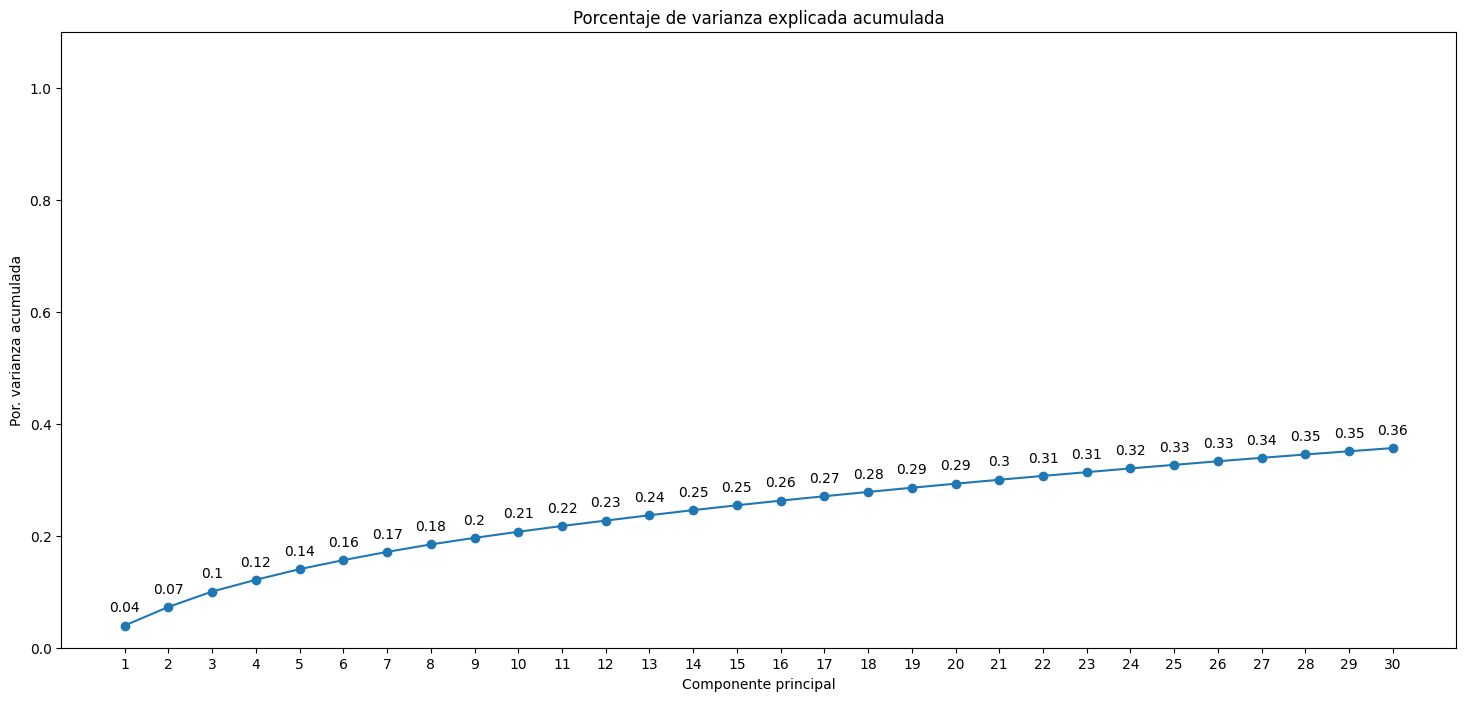

In [ ]:
%matplotlib inline
prop_varianza_acum = pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
ax.plot(
    np.arange(pca.n_components_) + 1,
    prop_varianza_acum,
    marker = 'o')
for x, y in zip(np.arange(pca.n_components_) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center')
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada')
plt.show()

In [4]:
km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(scaled_pcs)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['Grupo'])

In [6]:
with open('modelo_kmeans.pkl', 'wb') as file:
    pickle.dump(km, file)

In [74]:
data = datos.get(["headline_text"])
data["FAST"] = km.labels_
cluster_labels.value_counts()

C:\Users\acer\AppData\Local\Temp\ipykernel_24388\2649296106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["FAST"] = km.labels_


Grupo
1        566420
2        364905
0        312859
Name: count, dtype: int64

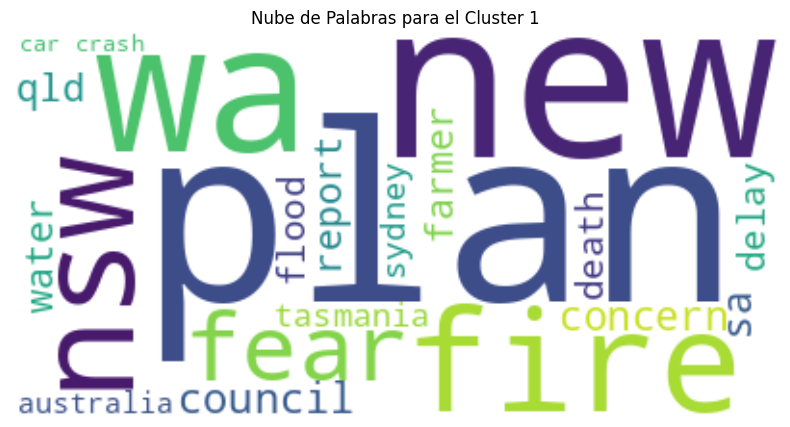

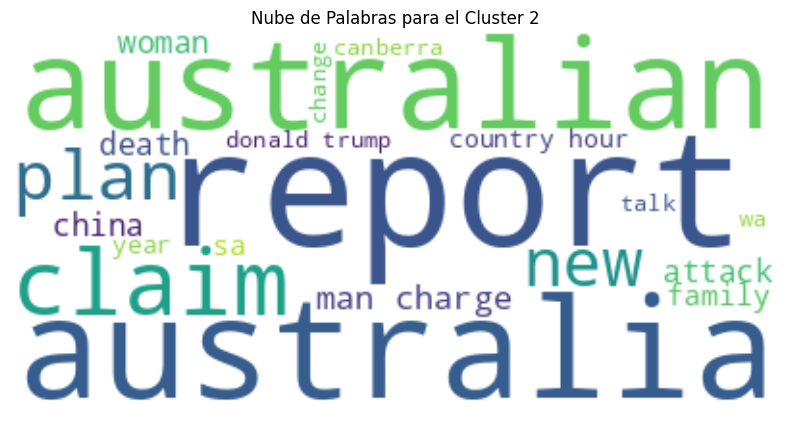

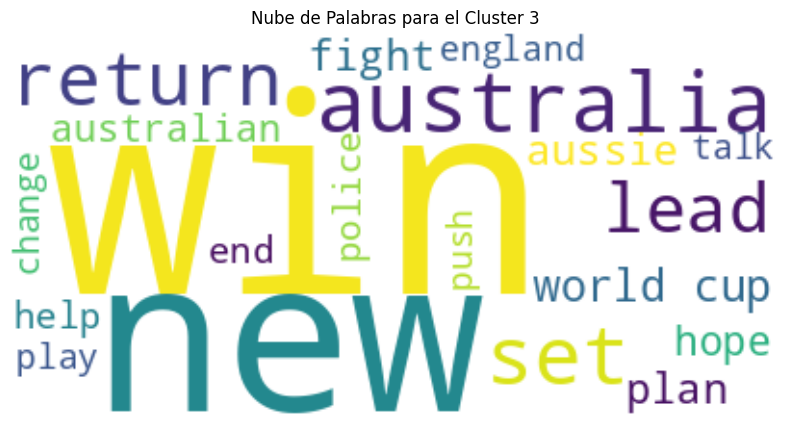

In [20]:
for i in range(km.n_clusters):
    cluster_texts = data[data['FAST'] == i]['headline_text']
    wordcloud = WordCloud(max_words=20, background_color='white').generate(' '.join(cluster_texts))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de Palabras para el Cluster {i+1}')
    plt.show()

## Modelo Bert

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [4]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return cls_embedding.flatten()

In [ ]:
%%time
datos['bert_embedding'] = datos['processed_text'].apply(get_bert_embedding)
embeddings = np.stack(datos['bert_embedding'].values)

CPU times: total: 21h 27min 20s
Wall time: 1d 13h 9min 22s


In [ ]:
np.save("news_embeddings.npy", embeddings)

In [5]:
embeddings = np.load("news_embeddings.npy")

In [5]:
embeddings.shape

(1244184, 768)

In [6]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(embeddings)

In [7]:
with open('modelo_kmeans_bert.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

In [76]:
data["BERT"] = kmeans.labels_
data["BERT"].value_counts()

C:\Users\acer\AppData\Local\Temp\ipykernel_24388\3130714462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["BERT"] = kmeans.labels_


BERT
0    567133
2    406454
1    270597
Name: count, dtype: int64

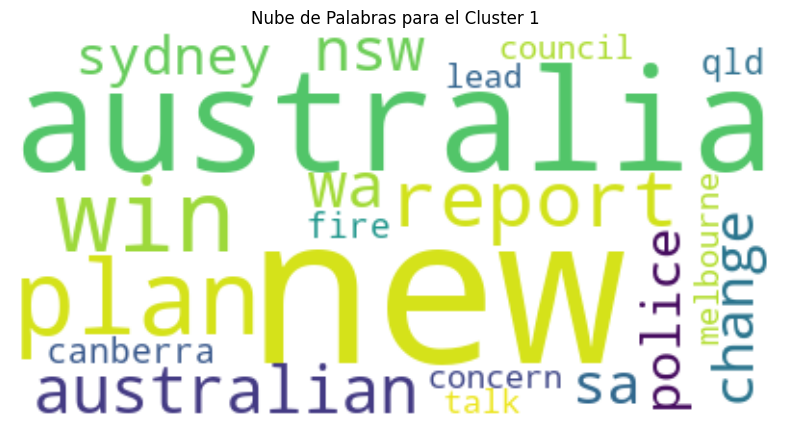

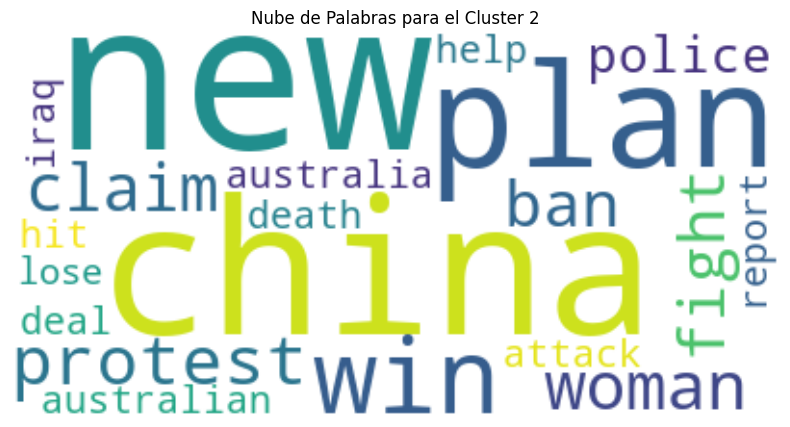

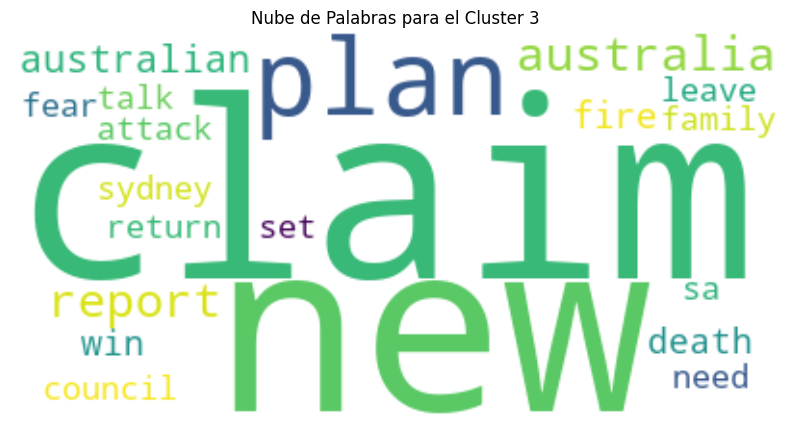

In [15]:
for i in range(kmeans.n_clusters):
    cluster_texts = data[data['BERT'] == i]['headline_text']
    wordcloud = WordCloud(max_words=20, background_color='white').generate(' '.join(cluster_texts))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de Palabras para el Cluster {i+1}')
    plt.show()

Temas por cluster:
* Cluster 1 = Internacionales
* Cluster 2 = Politica
* Cluster 3 = Deportes

## LDA sin TF-IDF

In [11]:
processed_docs = pd.read_pickle("news_proc_docs.pkl")

In [34]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [35]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=500)

In [96]:
dictionary.save("dictionary.dict")

In [12]:
dictionary = gensim.corpora.Dictionary.load("dictionary.dict")
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [77]:
%%time
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=3, id2word=dictionary, passes=2, workers=2)

CPU times: total: 2min 2s
Wall time: 3min 7s


In [78]:
with open("lda_model.pkl", "wb") as file:
    pickle.dump(lda_model, file)

In [79]:
with open("lda_model.pkl", "rb") as file:
    lda_model = pickle.load(file)

In [80]:
ind_without_tfidf = lda_model[bow_corpus]

In [81]:
%%time
topics_wo = []
for y in range(datos.shape[0]):
    if len(ind_without_tfidf[y]) > 0:
        valid_sublist = [sublist for sublist in ind_without_tfidf[y] if len(sublist) > 1]
        if len(valid_sublist) > 0:
            max_index = np.argmax([sublist[1] for sublist in valid_sublist])
            topics_wo.append(valid_sublist[max_index][0])
        else:
            topics_wo.append(None)
    else:
        topics_wo.append(None)

CPU times: total: 3min
Wall time: 10min 38s


In [82]:
data["topic_wo"] = topics_wo
topic_list = [x for x in data["topic_wo"].unique()]
topic_list = [x for x in np.sort(topic_list)]

C:\Users\acer\AppData\Local\Temp\ipykernel_24388\181245473.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["topic_wo"] = topics_wo


In [83]:
data["topic_wo"].value_counts()

topic_wo
0    515642
2    368665
1    359877
Name: count, dtype: int64

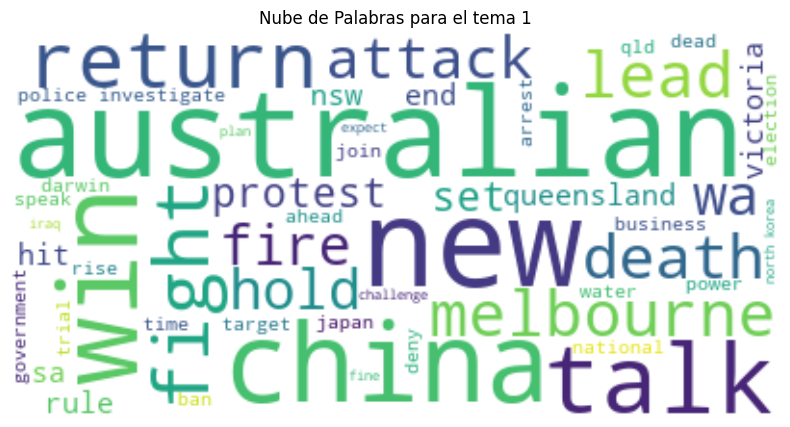

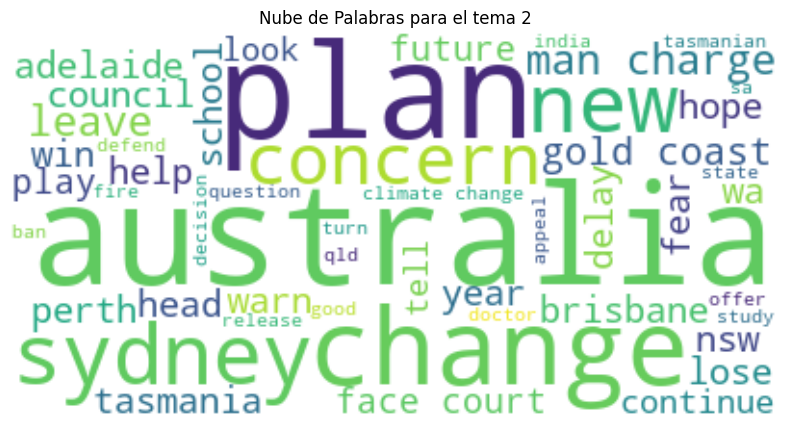

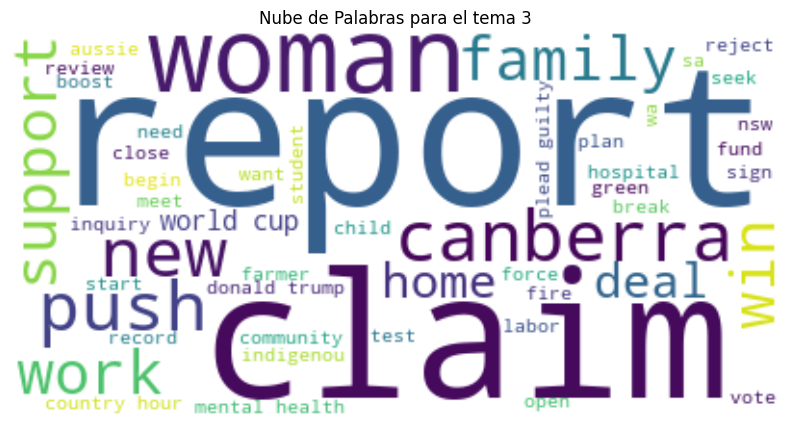

In [25]:
for i in range(len(topic_list)):
  cluster_texts = data[data['topic_wo'] == i]['headline_text']
  wordcloud = WordCloud(max_words = 50, background_color = 'white').generate(' '.join(cluster_texts))

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Nube de Palabras para el tema {1+i}')
  plt.show()

## LDA con TF-IDF

In [90]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [91]:
%%time
lda_tfidf_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=3, id2word=dictionary, passes=2, workers=4)

CPU times: total: 1min
Wall time: 2min 3s


In [93]:
with open("lda_tfidf_model.pkl", "wb") as file:
    pickle.dump(lda_tfidf_model, file)

In [94]:
with open("lda_tfidf_model.pkl", "rb") as file:
    lda_tfidf_model = pickle.load(file)

In [95]:
ind_with_tfidf = lda_tfidf_model[bow_corpus]

In [96]:
%%time
topics_w = []
for y in range(datos.shape[0]):
    if len(ind_with_tfidf[y]) > 0:
        valid_sublist = [sublist for sublist in ind_with_tfidf[y] if len(sublist) > 1]
        if len(valid_sublist) > 0:
            max_index = np.argmax([sublist[1] for sublist in valid_sublist])
            topics_w.append(valid_sublist[max_index][0])
        else:
            topics_w.append(None)
    else:
        topics_w.append(None)

CPU times: total: 2min 35s
Wall time: 16min 55s


In [98]:
data["topic_tfidf"] = topics_w
topic_list = [x for x in data["topic_tfidf"].unique()]
topic_list = [x for x in np.sort(topic_list)]

C:\Users\acer\AppData\Local\Temp\ipykernel_24388\720961350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["topic_tfidf"] = topics_w


In [99]:
data["topic_tfidf"].value_counts()

topic_tfidf
0    502635
1    379152
2    362397
Name: count, dtype: int64

In [100]:
data.to_csv("news_data.csv")

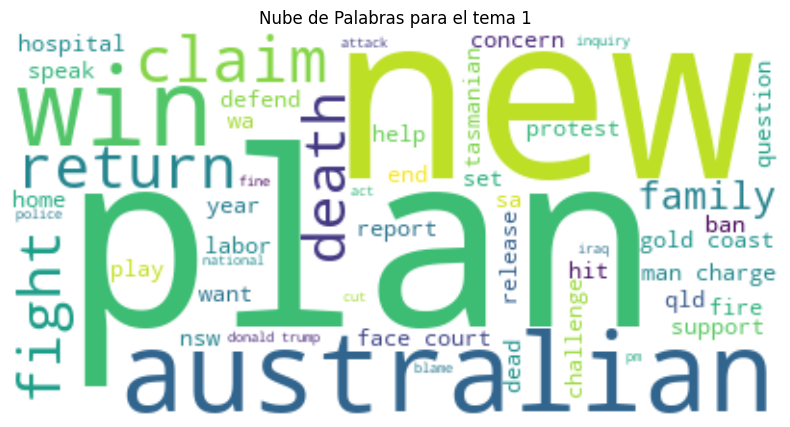

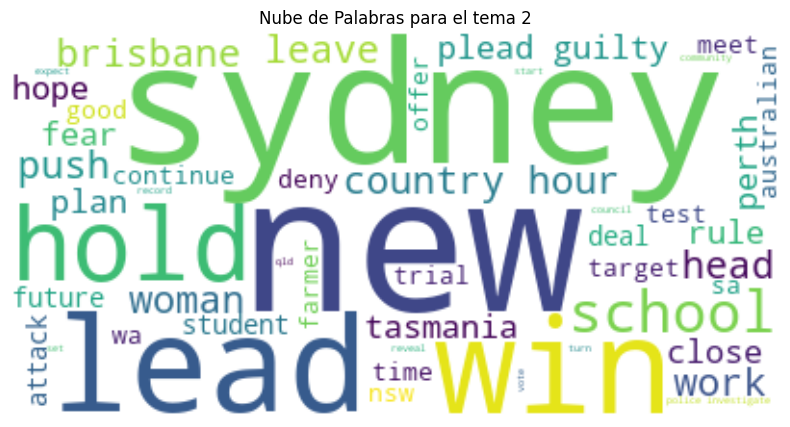

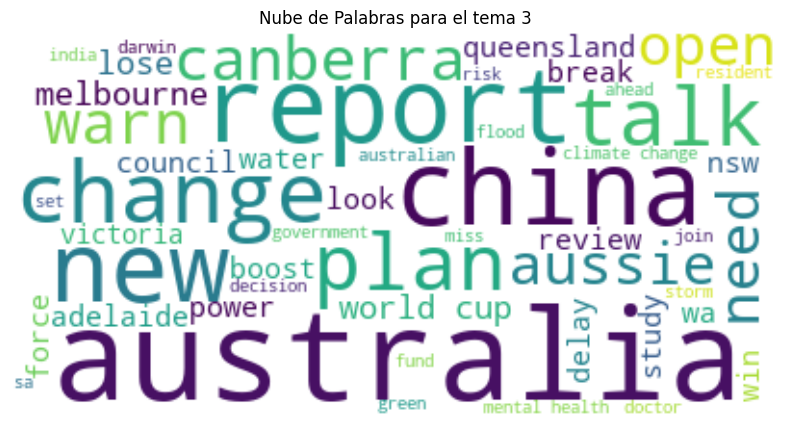

In [32]:
for i in range(len(topic_list)):
  cluster_texts = data[data['topic_tfidf'] == i]['headline_text']
  wordcloud = WordCloud(max_words = 50, background_color = 'white').generate(' '.join(cluster_texts))

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Nube de Palabras para el tema {1+i}')
  plt.show()

## Comparación modelos

In [101]:
data = pd.read_csv("news_data.csv", index_col=0)

In [102]:
round(pd.crosstab(data["FAST"],data["topic_wo"])/data.shape[0],2) # 0=3;1=1;2=2

topic_wo,0,1,2
FAST,,,
0,0.10,0.09,0.05
1,0.19,0.12,0.15
2,0.12,0.08,0.09


In [103]:
round(pd.crosstab(data["FAST"],data["topic_tfidf"])/data.shape[0],2) # IGUAL

topic_tfidf,0,1,2
FAST,,,
0,0.11,0.08,0.06
1,0.18,0.14,0.13
2,0.11,0.09,0.10


In [104]:
round(pd.crosstab(data["FAST"],data["BERT"])/data.shape[0],2) # IGUAL

BERT,0,1,2
FAST,,,
0,0.13,0.05,0.08
1,0.20,0.11,0.14
2,0.13,0.06,0.11


In [116]:
tabla_fast = pd.DataFrame({"GRUPO":[0,1,2], "TEMA":["TEMA 1","TEMA 2","TEMA 3"]})
tabla_wo = pd.DataFrame({"GRUPO":[0,1,2], "TEMA":["TEMA 3","TEMA 1","TEMA 2"]})
tabla_tfidf = pd.DataFrame({"GRUPO":[0,1,2], "TEMA":["TEMA 1","TEMA 2","TEMA 3"]})
tabla_bert = pd.DataFrame({"GRUPO":[0,1,2], "TEMA":["TEMA 1","TEMA 2","TEMA 3"]})

In [124]:
print("Para el Fast Text:")
print(tabla_fast)
print("Para el LDA sin TF-IDF:")
print(tabla_wo)
print("Para el LDA con TF-IDF:")
print(tabla_tfidf)
print("Para el modelo Bert:")
print(tabla_bert)

Para el Fast Text:
   GRUPO    TEMA
0      0  TEMA 1
1      1  TEMA 2
2      2  TEMA 3
Para el LDA sin TF-IDF:
   GRUPO    TEMA
0      0  TEMA 3
1      1  TEMA 1
2      2  TEMA 2
Para el LDA con TF-IDF:
   GRUPO    TEMA
0      0  TEMA 1
1      1  TEMA 2
2      2  TEMA 3
Para el modelo Bert:
   GRUPO    TEMA
0      0  TEMA 1
1      1  TEMA 2
2      2  TEMA 3


## Clasificación para nueva observación

In [2]:
import streamlit as st
import pandas as pd
import numpy as np
import pickle
import language_tool_python
import gensim
import fasttext
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
#noticia = "Global Markets Rally as Inflation Slows, Sparking Investor Optimism"
#noticia = "Breakthrough in Renewable Energy: Scientists Develop Solar Panel with Record Efficiency"
noticia = "Donald trump wins the election for president 2025"
#noticia = "aba decide community broadcasting licence"
nuevos = pd.DataFrame({"headline_text":[noticia]})

In [4]:
tool = language_tool_python.LanguageTool("en")

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load("en_core_web_lg")

stop_nltk = stopwords.words('english')
stop_spacy = nlp.Defaults.stop_words
stop_todas = list(stop_spacy.union(set(stop_nltk)))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
def lemmatize_stemming(text):
    ps = PorterStemmer()
    return ps.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [7]:
dictionary = gensim.corpora.Dictionary.load("dictionary.dict")

In [8]:
nuevos["errores"] = nuevos["headline_text"].apply(lambda x: tool.check(x))
nuevos["corregido"] = nuevos.apply(lambda c: language_tool_python.utils.correct(c["headline_text"], c["errores"]), axis = 1)

In [43]:
tokens = []
stop_words = set(STOP_WORDS)
nlp = spacy.load("en_core_web_lg")

for essay in nlp.pipe(nuevos['corregido'], batch_size=100, n_process=4):
    if essay.has_annotation("DEP"):
        tokens.append([e.text for e in essay])
    else:
        tokens.append(None)
nuevos['tokens'] = tokens

In [10]:
nuevos['processed_text'] = nuevos.apply(lambda row:  ' '.join(token.lemma_ for token in nlp(row["corregido"]).sents), axis=1)
nuevos['processed_text'] = nuevos['processed_text'].str.lower()
nuevos['processed_text'] = nuevos['processed_text'].replace(list('áéíóú'),list('aeiou'),regex=True)
nuevos['processed_text'] = nuevos['processed_text'].str.replace('[^\w\s]','')
nuevos['processed_text'] = nuevos['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_todas)]))

In [11]:
processed_nuevo = nuevos['processed_text'].map(preprocess)

In [12]:
bow_corpus_new = [dictionary.doc2bow(doc) for doc in processed_nuevo]

### LDA sin TF-IDF

In [13]:
with open("lda_model.pkl", "rb") as file:
    lda_model = pickle.load(file)

In [14]:
def topicos(indic,datos):
    topics = []
    for y in range(datos.shape[0]):
        if len(indic[y]) > 0:
            valid_sublist = [sublist for sublist in indic[y] if len(sublist) > 1]
            if len(valid_sublist) > 0:
                max_index = np.argmax([sublist[1] for sublist in valid_sublist])
                topics.append(valid_sublist[max_index][0])
            else:
                topics.append(None)
        else:
            topics.append(None)
    return topics

In [15]:
ind_wo_nuevo = lda_model[bow_corpus_new]

In [16]:
topics_wo_nuevo = topicos(ind_wo_nuevo, nuevos)

In [17]:
topics_wo_nuevo

[2]

In [18]:
temas = pd.DataFrame({"TEMA":["TEMA 1","TEMA 2", "TEMA 3"], "GRUPO":[0,1,2]})

In [19]:
topics_wo_nuevo[0]

2

In [20]:
temas["TEMA"][topics_wo_nuevo[0]]

'TEMA 3'

### LDA con TF-IDF

In [21]:
with open("lda_tfidf_model.pkl", "rb") as file:
    lda_tfidf_model = pickle.load(file)

In [22]:
ind_tfidf_nuevo = lda_tfidf_model[bow_corpus_new]

In [23]:
topics_tfidf_nuevo = topicos(ind_tfidf_nuevo, nuevos)

In [24]:
topics_tfidf_nuevo

[1]

In [26]:
temas = pd.DataFrame({"TEMA":["TEMA 3","TEMA 1", "TEMA 2"]})
temas["TEMA"][topics_tfidf_nuevo[0]]

'TEMA 1'

### Modelo Bert

In [27]:
with open("modelo_kmeans_bert.pkl", "rb") as file:
    kmeans_new = pickle.load(file)

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [29]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return cls_embedding.flatten()

In [30]:
nuevos['bert_embedding'] = nuevos['processed_text'].apply(get_bert_embedding)
embeddings_nuevo = np.stack(nuevos['bert_embedding'].values)

In [31]:
bert = kmeans_new.predict(embeddings_nuevo)

In [32]:
bert[0]

1

In [33]:
temas["TEMA"][bert[0]]

'TEMA 1'

## Modelo Fast Text

In [34]:
with open("modelo_kmeans.pkl", "rb") as file:
    km_new = pickle.load(file)

In [35]:
with open("pca_fast.pkl", "rb") as file:
    pca = pickle.load(file)

In [36]:
with open("scaler_fast.pkl", "rb") as file:
    scaler = pickle.load(file)

In [37]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.get_word_vector(word))
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.words)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [38]:
ft_model = fasttext.load_model("fasttext_model.bin")

In [39]:
ftext_nuevo = averaged_word_vectorizer(corpus=nuevos['tokens'], model=ft_model, num_features=ft_model.get_dimension())

In [40]:
doc_embedding_new = pd.DataFrame(ftext_nuevo)

In [41]:
pcs_new = pca.transform(doc_embedding_new)
scaler_new = scaler.transform(pcs_new)

In [42]:
fast = km_new.predict(scaler_new)
fast[0]

1